In [ ]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta


In [103]:
ticker_symbol='DELTACORP.NS'

In [104]:
Data=yf.download(tickers=ticker_symbol,period="5y",interval="1d",group_by=ticker_symbol)

C:\Users\PC\AppData\Local\Temp\ipykernel_7452\2880522541.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  Data=yf.download(tickers=ticker_symbol,period="5y",interval="1d",group_by=ticker_symbol)
[*********************100%***********************]  1 of 1 completed


In [105]:
Data.columns = Data.columns.droplevel(0)
Data.head(5)

Price            Open       High        Low      Close   Volume
Date                                                           
2020-07-10  89.794280  91.450819  88.819844  89.696838  1018294
2020-07-13  89.745552  90.525104  88.430065  89.112167   781004
2020-07-14  89.550668  89.891719  85.750366  87.114578   891011
2020-07-15  86.724800  91.450813  85.750364  91.353371  2093109
2020-07-16  91.791873  93.156085  87.796687  88.283905  2534417

## Add Useful KPIs

In [106]:
Data['RSI']=ta.rsi(Data["Close"], length=14)

info = yf.Ticker(ticker_symbol).info
Data['Sector']=info.get("sector")
Data['Industry']=info.get("industry")

MACD=ta.macd(Data["Close"], fast=12, slow=26, signal=9)
Data=pd.concat([Data,MACD],axis=1)

Data.rename(columns={
    "MACD_12_26_9": "MACD_Line",
    "MACDs_12_26_9": "MACD_Signal",
    "MACDh_12_26_9": "MACD_Histogram"
}, inplace=True)


Data["EMA_20"] = ta.ema(Data["Close"], length=20)
Data["EMA_50"] = ta.ema(Data["Close"], length=50)

# Add Bollinger Bands (20-day default)
bbands = ta.bbands(Data["Close"], length=20)

# Combine with main DataFrame
Data = pd.concat([Data, bbands], axis=1)

# Optional rename (if needed)
Data.rename(columns={
    "BBL_20_2.0": "BB_Lower",
    "BBM_20_2.0": "BB_Middle",
    "BBU_20_2.0": "BB_Upper",
    "BBB_20_2.0": "BB_Bandwidth",
    "BBP_20_2.0": "BB_Percent"
}, inplace=True)

# Add ADX (default 14-period)
adx_df = ta.adx(Data["High"], Data["Low"], Data["Close"], length=14)

# Join it with main DataFrame
Data = pd.concat([Data, adx_df], axis=1)

# Optional rename (for clarity)
Data.rename(columns={
    "ADX_14": "ADX",
    "DMP_14": "DI_Plus",
    "DMN_14": "DI_Minus"
}, inplace=True)

# Add ATR (default length=14)
Data["ATR_14"] = ta.atr(Data["High"], Data["Low"], Data["Close"], length=14)

# Add Stochastic Oscillator (default k=14, d=3)
stoch_df = ta.stoch(Data["High"], Data["Low"], Data["Close"], k=14, d=3)

# Combine with main DataFrame
Data = pd.concat([Data, stoch_df], axis=1)

# Optional rename
Data.rename(columns={
    "STOCHk_14_3_3": "Stoch_%K",
    "STOCHd_14_3_3": "Stoch_%D"
}, inplace=True)



# Add CCI (default period = 20)
Data["CCI_20"] = ta.cci(Data["High"], Data["Low"], Data["Close"], length=20)

In [107]:
Data.to_csv("test.csv")

In [108]:
Data.reset_index(inplace=True)

## Feature Engineering

In [109]:
Data['Volume1']=Data['Volume'].shift(1)
Data['Volume_Inc']=(Data['Volume']-Data['Volume1'])/Data['Volume1']

Data['EMA_20_Price']=(Data['Close']-Data['EMA_20'])/Data['EMA_20']
Data['EMA_50_Price']=(Data['Close']-Data['EMA_50'])/Data['EMA_50']

Data['Stoch_k_D']=(Data['Stoch_%K']-Data['Stoch_%D'])

Data['Close1']=Data['Close'].shift(10)
Data['Close_Inc']=(Data['Close1']-Data['Close'])/Data['Close']

Data.head(50)

def Buy_Variable(row):
    if row['Close_Inc']>=0.03:
        return 1
    else:
        return 0

Data['Buy']=Data.apply(Buy_Variable,axis=1)

## Data Clean

In [110]:
Clean_Data=Data[['RSI', 'MACD_Histogram','BB_Percent','ADX','ATR_14', 'Stoch_%K',
       'Stoch_%D', 'CCI_20','Volume_Inc', 'EMA_20_Price',
       'EMA_50_Price', 'Stoch_k_D', 'Buy']]

Clean_Data=Clean_Data.dropna(subset=['RSI', 'MACD_Histogram','BB_Percent','ADX','ATR_14', 'Stoch_%K',
       'Stoch_%D', 'CCI_20','Volume_Inc', 'EMA_20_Price',
       'EMA_50_Price'])

Clean_Data.head(10)

RSI  MACD_Histogram  BB_Percent        ADX    ATR_14   Stoch_%K  \
49  49.007251       -0.971787    0.303352  22.137198  4.777334  47.285993   
50  58.368308       -0.570449    0.712624  21.857264  5.191016  53.673503   
51  50.041613       -0.622369    0.384064  21.296327  5.538100  50.514644   
52  42.646456       -0.994663    0.044365  20.244915  5.813056  43.777132   
53  43.668781       -1.151096    0.127489  19.277090  5.808401  26.819257   
54  41.934970       -1.288888    0.065591  18.482908  5.676474  17.422251   
55  44.640183       -1.218278    0.189969  17.444380  5.504745  18.933361   
56  48.813518       -0.955783    0.407288  16.590801  5.448231  23.911144   
57  55.545681       -0.444682    0.777691  16.822680  5.611319  40.000024   
58  53.893096       -0.170437    0.706876  17.036726  5.522515  51.377812   

     Stoch_%D      CCI_20  Volume_Inc  EMA_20_Price  EMA_50_Price  Stoch_k_D  \
49  46.334954  -54.945552   -0.077954     -0.011713      0.046104   0.951039   
50  50.460684   56.322357    4.509873      0.038895      0.099701   3.212819   
51  50.491380   14.610392   -0.442360     -0.006434      0.048909   0.023264   
52  49.321759 -129.675101   -0.112712     -0.053125     -0.005710  -5.544628   
53  40.370344 -129.796891   -0.507448     -0.042868      0.000525 -13.551087   
54  29.339546 -146.834219    0.256194     -0.050717     -0.012449 -11.917295   
55  21.058290 -105.193544   -0.339572     -0.032598      0.002843  -2.124929   
56  20.088919  -25.562637    0.394155     -0.007650      0.026755   3.822225   
57  27.614843   71.252319    2.178651      0.033750      0.070323  12.385181   
58  38.429660   69.404752   -0.624128      0.021687      0.057753  12.948152   

    Buy  
49    1  
50    0  
51    0  
52    1  
53    0  
54    1  
55    0  
56    1  
57    0  
58    0

## Visualize

C:\Users\PC\AppData\Local\Temp\ipykernel_7452\314450490.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_7452\314450490.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


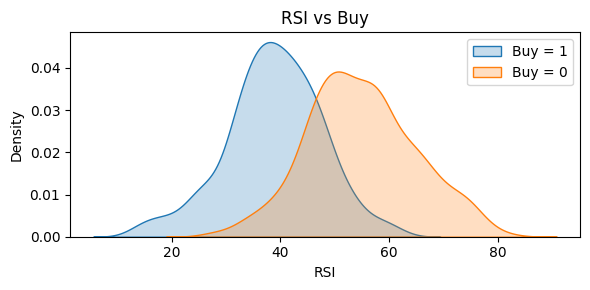

C:\Users\PC\AppData\Local\Temp\ipykernel_7452\314450490.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_7452\314450490.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


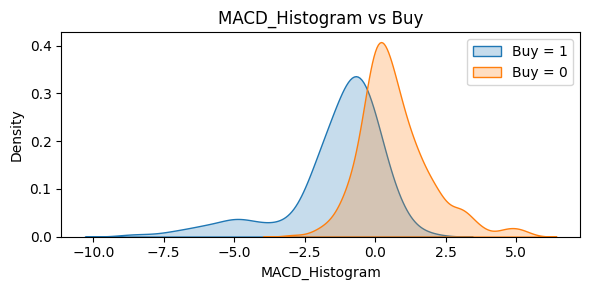

C:\Users\PC\AppData\Local\Temp\ipykernel_7452\314450490.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_7452\314450490.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


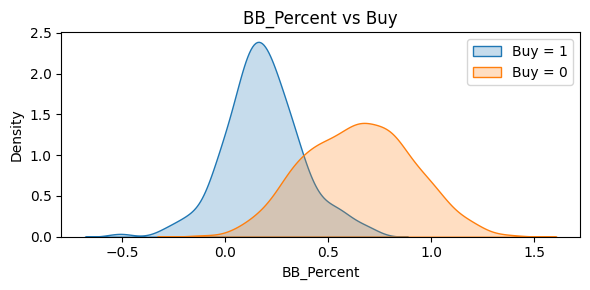

C:\Users\PC\AppData\Local\Temp\ipykernel_7452\314450490.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_7452\314450490.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


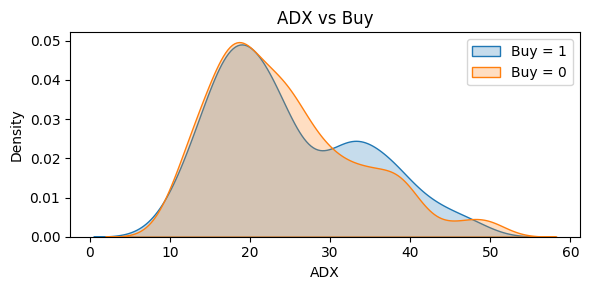

C:\Users\PC\AppData\Local\Temp\ipykernel_7452\314450490.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_7452\314450490.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


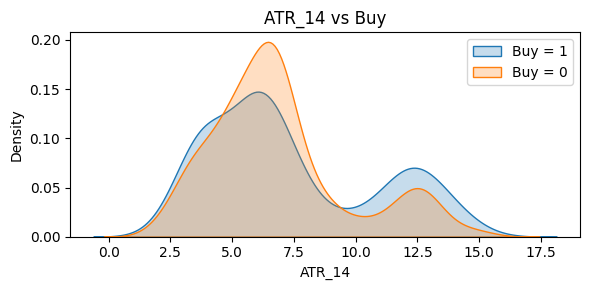

C:\Users\PC\AppData\Local\Temp\ipykernel_7452\314450490.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_7452\314450490.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


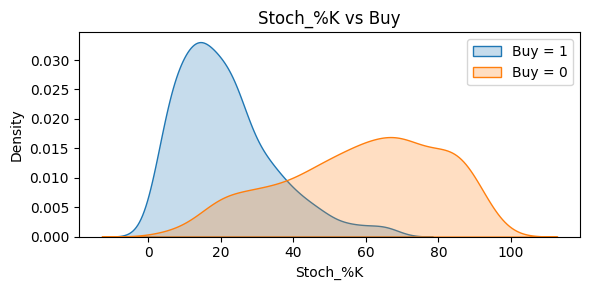

C:\Users\PC\AppData\Local\Temp\ipykernel_7452\314450490.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_7452\314450490.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


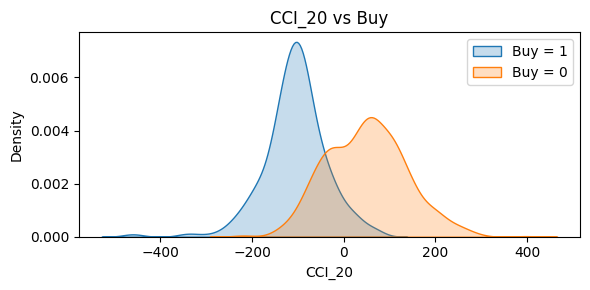

C:\Users\PC\AppData\Local\Temp\ipykernel_7452\314450490.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_7452\314450490.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


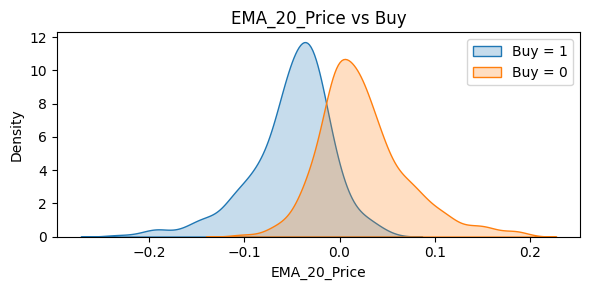

C:\Users\PC\AppData\Local\Temp\ipykernel_7452\314450490.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
C:\Users\PC\AppData\Local\Temp\ipykernel_7452\314450490.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)


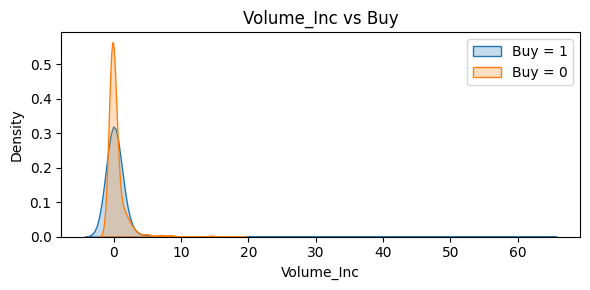

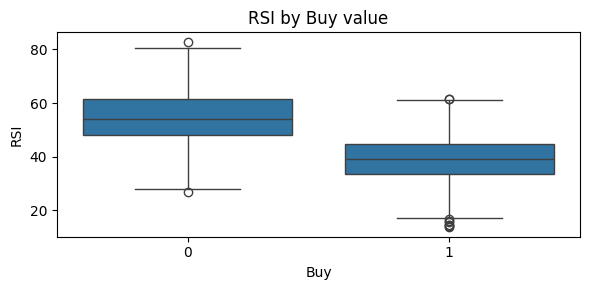

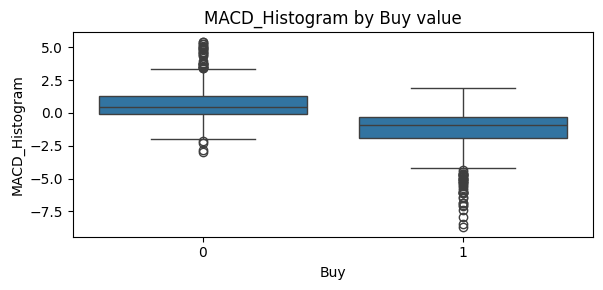

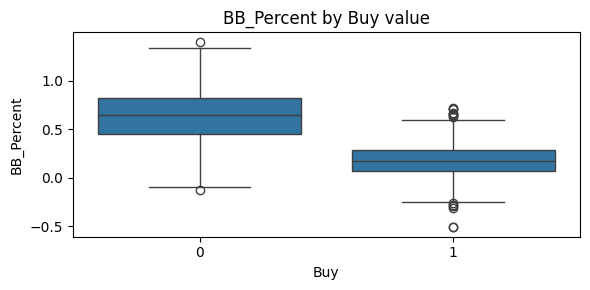

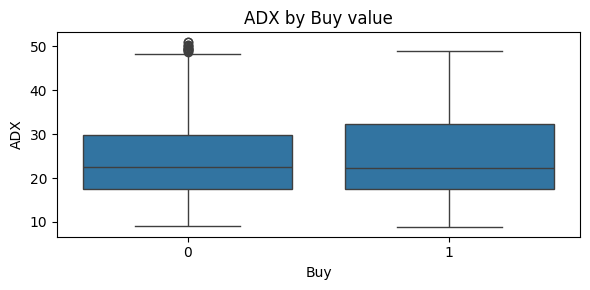

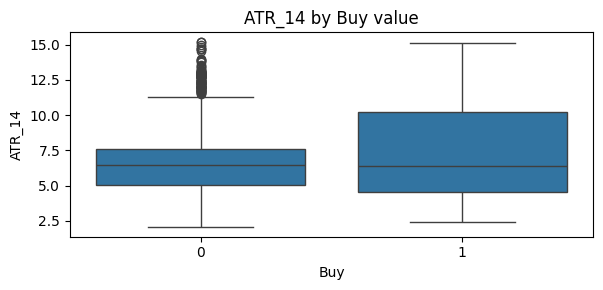

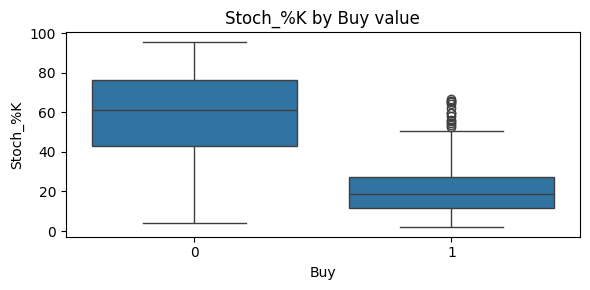

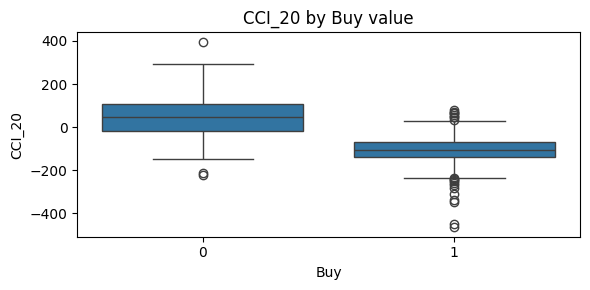

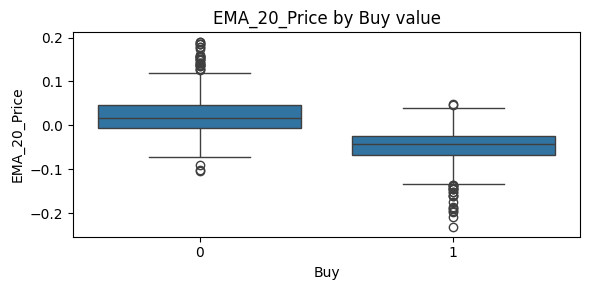

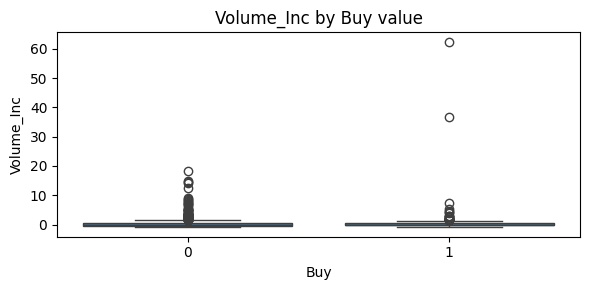

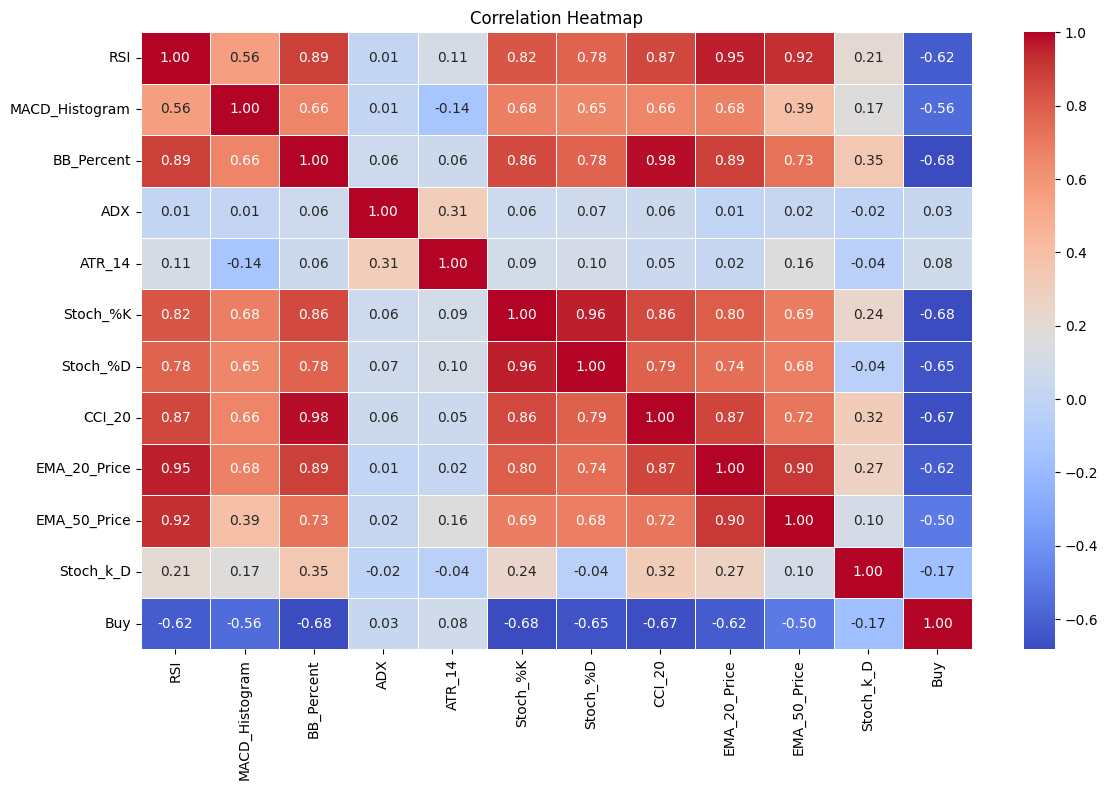

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt

features = ["RSI", "MACD_Histogram", "BB_Percent", "ADX", "ATR_14", 
            "Stoch_%K", "CCI_20", "EMA_20_Price", "Volume_Inc"]

for feature in features:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 1], x=feature, label="Buy = 1", shade=True)
    sns.kdeplot(data=Clean_Data[Clean_Data["Buy"] == 0], x=feature, label="Buy = 0", shade=True)
    plt.title(f"{feature} vs Buy")
    plt.legend()
    plt.tight_layout()
    plt.show()


for feature in features:
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=Clean_Data, x="Buy", y=feature)
    plt.title(f"{feature} by Buy value")
    plt.tight_layout()
    plt.show()


Clean_Data.drop(columns="Volume_Inc",inplace=True)

# Step 1: Compute correlation matrix
corr_matrix = Clean_Data.corr()

# Step 2: Set up the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [112]:
Clean_Data.head(5)

RSI  MACD_Histogram  BB_Percent        ADX    ATR_14   Stoch_%K  \
49  49.007251       -0.971787    0.303352  22.137198  4.777334  47.285993   
50  58.368308       -0.570449    0.712624  21.857264  5.191016  53.673503   
51  50.041613       -0.622369    0.384064  21.296327  5.538100  50.514644   
52  42.646456       -0.994663    0.044365  20.244915  5.813056  43.777132   
53  43.668781       -1.151096    0.127489  19.277090  5.808401  26.819257   

     Stoch_%D      CCI_20  EMA_20_Price  EMA_50_Price  Stoch_k_D  Buy  
49  46.334954  -54.945552     -0.011713      0.046104   0.951039    1  
50  50.460684   56.322357      0.038895      0.099701   3.212819    0  
51  50.491380   14.610392     -0.006434      0.048909   0.023264    0  
52  49.321759 -129.675101     -0.053125     -0.005710  -5.544628    1  
53  40.370344 -129.796891     -0.042868      0.000525 -13.551087    0

## Model Build

In [113]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Clean_Data.drop("Buy", axis=1))



X_scaled

from sklearn.model_selection import train_test_split
y=Clean_Data['Buy']

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

### Logisitic

In [114]:
from sklearn.linear_model import LogisticRegression

model=LogisticRegression()
model.fit(X_train, y_train)
y=model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
from sklearn.metrics import classification_report,roc_auc_score
print("ðŸ”¹ Logistic Regression:")
print(classification_report(y_test, y))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

ðŸ”¹ Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       157
           1       0.84      0.83      0.83        82

    accuracy                           0.89       239
   macro avg       0.88      0.87      0.87       239
weighted avg       0.89      0.89      0.89       239

ROC AUC Score: 0.9485


### Random Forest

In [115]:
from sklearn.ensemble import RandomForestClassifier

model=RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y=model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
feature_importances = model.feature_importances_
features = Clean_Data.drop("Buy", axis=1).columns
# Combine into a DataFrame
F_Imp = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
}).sort_values("Importance", ascending=False)
print(F_Imp)
from sklearn.metrics import classification_report
print("ðŸ”¹ RandomForestClassifier:")
print(classification_report(y_test, y))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

           Feature  Importance
7           CCI_20    0.210412
2       BB_Percent    0.161373
5         Stoch_%K    0.114916
8     EMA_20_Price    0.104752
6         Stoch_%D    0.098283
1   MACD_Histogram    0.095573
0              RSI    0.069533
9     EMA_50_Price    0.043587
4           ATR_14    0.035219
3              ADX    0.034464
10       Stoch_k_D    0.031888
ðŸ”¹ RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       157
           1       0.88      0.80      0.84        82

    accuracy                           0.90       239
   macro avg       0.89      0.87      0.88       239
weighted avg       0.89      0.90      0.89       239

ROC AUC Score: 0.9506


### XG Boost

In [116]:
from xgboost import XGBClassifier
model=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)
y=model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
feature_importances = model.feature_importances_
features = Clean_Data.drop("Buy", axis=1).columns
# Combine into a DataFrame
F_Imp = pd.DataFrame({
    "Feature": features,
    "Importance": feature_importances
}).sort_values("Importance", ascending=False)
print(F_Imp)
from sklearn.metrics import classification_report
print("ðŸ”¹ XGBClassifier: ")
print(classification_report(y_test, y))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

           Feature  Importance
2       BB_Percent    0.316289
7           CCI_20    0.206575
5         Stoch_%K    0.140195
8     EMA_20_Price    0.074188
1   MACD_Histogram    0.059806
6         Stoch_%D    0.046218
9     EMA_50_Price    0.042599
4           ATR_14    0.032715
0              RSI    0.028847
10       Stoch_k_D    0.026764
3              ADX    0.025804
ðŸ”¹ XGBClassifier: 
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       157
           1       0.82      0.82      0.82        82

    accuracy                           0.87       239
   macro avg       0.86      0.86      0.86       239
weighted avg       0.87      0.87      0.87       239

ROC AUC Score: 0.9517


C:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [00:51:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [120]:
data_Test = yf.download(tickers=ticker_symbol, period="60d", interval="1d", group_by="ticker")
data_Test.columns = data_Test.columns.droplevel(0)

C:\Users\PC\AppData\Local\Temp\ipykernel_7452\2986124501.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_Test = yf.download(tickers=ticker_symbol, period="60d", interval="1d", group_by="ticker")
[*********************100%***********************]  1 of 1 completed


In [121]:
data_Test['RSI']=ta.rsi(data_Test["Close"], length=14)

info = yf.Ticker(ticker_symbol).info
data_Test['Sector']=info.get("sector")
data_Test['Industry']=info.get("industry")

MACD=ta.macd(data_Test["Close"], fast=12, slow=26, signal=9)
data_Test=pd.concat([data_Test,MACD],axis=1)

data_Test.rename(columns={
    "MACD_12_26_9": "MACD_Line",
    "MACDs_12_26_9": "MACD_Signal",
    "MACDh_12_26_9": "MACD_Histogram"
}, inplace=True)


data_Test["EMA_20"] = ta.ema(data_Test["Close"], length=20)
data_Test["EMA_50"] = ta.ema(data_Test["Close"], length=50)

# Add Bollinger Bands (20-day default)
bbands = ta.bbands(data_Test["Close"], length=20)

# Combine with main DataFrame
data_Test = pd.concat([data_Test, bbands], axis=1)

# Optional rename (if needed)
data_Test.rename(columns={
    "BBL_20_2.0": "BB_Lower",
    "BBM_20_2.0": "BB_Middle",
    "BBU_20_2.0": "BB_Upper",
    "BBB_20_2.0": "BB_Bandwidth",
    "BBP_20_2.0": "BB_Percent"
}, inplace=True)

# Add ADX (default 14-period)
adx_df = ta.adx(data_Test["High"], data_Test["Low"], data_Test["Close"], length=14)

# Join it with main DataFrame
data_Test = pd.concat([data_Test, adx_df], axis=1)

# Optional rename (for clarity)
data_Test.rename(columns={
    "ADX_14": "ADX",
    "DMP_14": "DI_Plus",
    "DMN_14": "DI_Minus"
}, inplace=True)

# Add ATR (default length=14)
data_Test["ATR_14"] = ta.atr(data_Test["High"], data_Test["Low"], data_Test["Close"], length=14)

# Add Stochastic Oscillator (default k=14, d=3)
stoch_df = ta.stoch(data_Test["High"], data_Test["Low"], data_Test["Close"], k=14, d=3)

# Combine with main DataFrame
data_Test = pd.concat([data_Test, stoch_df], axis=1)

# Optional rename
data_Test.rename(columns={
    "STOCHk_14_3_3": "Stoch_%K",
    "STOCHd_14_3_3": "Stoch_%D"
}, inplace=True)



# Add CCI (default period = 20)
data_Test["CCI_20"] = ta.cci(data_Test["High"], data_Test["Low"], data_Test["Close"], length=20)

In [122]:
data_Test

Open       High        Low      Close   Volume        RSI  \
Date                                                                         
2025-04-16  82.480003  83.919998  82.279999  82.870003   833555        NaN   
2025-04-17  83.449997  84.750000  82.199997  83.879997  1053598        NaN   
2025-04-21  85.000000  86.500000  84.500000  86.330002  1213940        NaN   
2025-04-22  87.400002  94.000000  85.459999  93.230003  9651969        NaN   
2025-04-23  93.500000  95.180000  91.419998  93.690002  6363917        NaN   
2025-04-24  93.500000  95.480003  92.760002  94.209999  2447721        NaN   
2025-04-25  94.800003  94.800003  89.519997  91.330002  2112971        NaN   
2025-04-28  91.699997  92.339996  90.389999  91.669998  1147167        NaN   
2025-04-29  92.199997  93.620003  91.150002  91.660004  1029542        NaN   
2025-04-30  91.660004  96.250000  89.800003  92.580002  4081272        NaN   
2025-05-02  93.000000  95.019997  91.650002  94.559998  1584743        NaN   
2025-05-05  93.900002  94.750000  92.510002  93.199997   987032        NaN   
2025-05-06  94.099998  94.129997  89.400002  90.010002  1205937        NaN   
2025-05-07  90.010002  91.349998  88.260002  91.050003  1172332        NaN   
2025-05-08  91.790001  92.900002  87.660004  88.410004  1741911  50.397703   
2025-05-09  86.690002  87.800003  83.250000  84.550003  2729541  40.149204   
2025-05-12  89.000000  91.330002  88.209999  89.739998  1727324  53.763586   
2025-05-13  90.000000  91.910004  89.160004  90.989998  1331464  56.339573   
2025-05-14  91.489998  92.300003  90.930000  91.480003   990441  57.342864   
2025-05-15  92.000000  93.849998  91.779999  93.339996  1068278  61.005836   
2025-05-16  93.699997  94.290001  92.949997  93.580002  1190188  61.465652   
2025-05-19  94.099998  95.750000  93.330002  94.349998  1247879  62.974142   
2025-05-20  94.500000  94.889999  91.720001  92.110001   732654  56.094610   
2025-05-21  92.000000  92.949997  91.050003  91.550003   799075  54.491911   
2025-05-22  91.500000  93.000000  91.199997  92.690002   605270  57.174397   
2025-05-23  91.510002  92.980003  91.250000  91.519997   802420  53.677301   
2025-05-26  92.800003  93.300003  91.250000  91.379997   727458  53.257532   
2025-05-27  91.519997  93.620003  89.760002  90.720001  1132999  51.223813   
2025-05-28  91.400002  91.970001  90.599998  91.029999   927513  52.148109   
2025-05-29  91.699997  94.000000  91.500000  91.790001  1958789  54.428140   
2025-05-30  92.489998  93.550003  91.279999  92.690002  1034191  57.038691   
2025-06-02  92.400002  93.599998  91.900002  92.449997   855707  56.115522   
2025-06-03  92.550003  93.150002  90.699997  90.970001  1007100  50.669469   
2025-06-04  90.949997  91.800003  89.769997  90.040001   856476  47.546789   
2025-06-05  90.050003  92.089996  90.050003  90.919998   651247  50.646236   
2025-06-06  90.919998  92.949997  90.360001  90.839996  1996449  50.354925   
2025-06-09  92.000000  93.000000  91.209999  91.809998  1172110  53.823034   
2025-06-10  92.489998  93.480003  91.860001  91.980003  1266214  54.423971   
2025-06-11  92.489998  96.000000  92.290001  94.529999  3424181  62.340557   
2025-06-12  94.820000  94.900002  91.550003  92.010002  1180423  52.614210   
2025-06-13  92.000000  92.169998  90.220001  90.989998  1044161  49.263831   
2025-06-16  91.279999  91.660004  89.610001  90.550003   885342  47.848400   
2025-06-17  90.500000  91.750000  89.470001  89.620003   792275  44.911189   
2025-06-18  89.570000  90.190002  88.120003  88.360001   939048  41.219357   
2025-06-19  88.360001  88.970001  86.500000  86.720001   701048  36.960595   
2025-06-20  86.540001  88.510002  86.529999  87.559998   573147  40.359521   
2025-06-23  86.559998  87.660004  86.559998  86.949997   599092  38.726559   
2025-06-24  88.000000  89.459999  88.000000  88.830002   727706  45.980794   
2025-06-25  89.800003  90.629997  87.860001  89.980003  1578954  49.888992   
2025-06-26  89.989998  92.239998  89.63

In [124]:
data_Test['Volume1']=data_Test['Volume'].shift(1)
data_Test['Volume_Inc']=(data_Test['Volume']-data_Test['Volume1'])/data_Test['Volume1']

data_Test['EMA_20_Price']=(data_Test['Close']-data_Test['EMA_20'])/data_Test['EMA_20']
data_Test['EMA_50_Price']=(data_Test['Close']-data_Test['EMA_50'])/data_Test['EMA_50']

data_Test['Stoch_k_D']=(data_Test['Stoch_%K']-data_Test['Stoch_%D'])

data_Test['Close1']=data_Test['Close'].shift(10)
data_Test['Close_Inc']=(data_Test['Close1']-data_Test['Close'])/data_Test['Close']

data_Test.head(50)

def Buy_Variable(row):
    if row['Close_Inc']>=0.03:
        return 1
    else:
        return 0

data_Test['Buy']=data_Test.apply(Buy_Variable,axis=1)

In [125]:
Clean_Data_Test=data_Test[['RSI', 'MACD_Histogram','BB_Percent','ADX','ATR_14', 'Stoch_%K',
       'Stoch_%D', 'CCI_20','Volume_Inc', 'EMA_20_Price',
       'EMA_50_Price', 'Stoch_k_D', 'Buy']]

In [127]:
# Step 1: Get feature columns (same as used during training)
features = ['RSI', 'MACD_Histogram', 'BB_Percent', 'ADX', 'ATR_14',
            'Stoch_%K', 'Stoch_%D', 'CCI_20', 'EMA_20_Price', 'EMA_50_Price', 'Stoch_k_D']

# Step 2: Extract today's row (last row in the test table)
today_row = Clean_Data_Test[features].iloc[-1:]  # Keep it as DataFrame

# Step 3: Apply the same scaler used during training
today_scaled = scaler.transform(today_row)

# Step 4: Predict using the trained model
buy_prediction = model.predict(today_scaled)[0]
buy_probability = model.predict_proba(today_scaled)[0][1]

# Step 5: Print result
print("ðŸ”® Buy Prediction:", "Yes" if buy_prediction == 1 else "No")
print(f"ðŸ“Š Confidence: {buy_probability:.2%}")


ðŸ”® Buy Prediction: No
ðŸ“Š Confidence: 0.02%
